

## 训练

在了解了上述统计工具后，让我们在实践中尝试一下！
首先，我们生成一些数据：(**使用正弦函数和一些可加性噪声来生成序列数据，
时间步为$1, 2, \ldots, 1000$。**)


In [110]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

tensor([-0.3465, -0.0504,  0.1437,  0.1935,  0.2430, -0.5551,  0.1014, -0.3912,
         0.2373, -0.0366,  0.4552,  0.1092,  0.2526,  0.1788,  0.0089,  0.6898,
         0.0772,  0.3099,  0.0254,  0.2757,  0.2989,  0.4333,  0.1697,  0.3397,
         0.2776,  0.1250,  0.2762,  0.5451,  0.3615,  0.3048,  0.5897,  0.4797,
         0.1543,  0.7031,  0.2856,  0.3616,  0.4731,  0.4865,  0.3370,  0.2650,
         0.7338,  0.4279,  0.5981,  0.7265,  0.5493,  0.2251,  0.3657,  0.7711,
         0.6748,  0.1804,  0.7321,  0.5100,  0.5269,  0.6200,  0.5564,  1.0015,
         0.4530,  0.6283,  0.3416,  0.5902,  0.5358,  0.4753,  0.8510,  0.5288,
         0.7686,  0.5022,  0.6137,  1.0270,  0.2181,  0.8871,  0.6438,  1.0814,
         0.8618,  0.5786,  0.3696,  0.7697,  0.6702,  0.8681,  0.5664,  0.8894,
         0.4979,  0.7676,  0.3277,  0.7023,  0.6273,  1.0717,  1.1365,  0.8485,
         0.4329,  0.7035,  0.7912,  1.0716,  0.9948,  1.1279,  0.5303,  0.9587,
         0.6494,  1.0292,  0.5921,  0.90

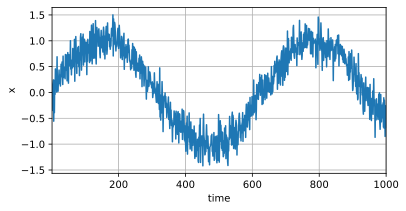

In [111]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
#? 生成的time 就是一个tensor 数据是1.0 2.0 3.0 ->1000.0
# print(time)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
#? 此时 x 就是 每一个上面的值的计算结果 y = sin(0.01* x) + 噪音
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))
print(x)

接下来，我们将这个序列转换为模型的*特征－标签*（feature-label）对。
基于嵌入维度$\tau$，我们[**将数据映射为数据对$y_t = x_t$
和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]
这比我们提供的数据样本少了$\tau$个，
因为我们没有足够的历史记录来描述前$\tau$个数据样本。
一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；
另一个方法是用零填充序列。
在这里，我们仅使用前600个“特征－标签”对进行训练。


也就是说，每一个$y_t = x_t$

In [112]:
tau = 4
features = torch.zeros((T - tau, tau))
print(features)
print(features.shape)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

print(features)
print(features.shape)
#?featurs一共有996行，4列。
#?第i行，表示第i+4个元素，的前4个位置的元素的值。也就是i i+1 i+2 i+3
#?最后一共 996行。
#?此时第一个features[0]就是整个序列的第五个元素的前面四个的元素的值。

print(labels)
print(labels.shape)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
torch.Size([996, 4])
tensor([[-0.3465, -0.0504,  0.1437,  0.1935],
        [-0.0504,  0.1437,  0.1935,  0.2430],
        [ 0.1437,  0.1935,  0.2430, -0.5551],
        ...,
        [-0.6898, -0.1489, -0.3134, -0.8502],
        [-0.1489, -0.3134, -0.8502, -0.2566],
        [-0.3134, -0.8502, -0.2566, -0.5325]])
torch.Size([996, 4])
tensor([[ 0.2430],
        [-0.5551],
        [ 0.1014],
        [-0.3912],
        [ 0.2373],
        [-0.0366],
        [ 0.4552],
        [ 0.1092],
        [ 0.2526],
        [ 0.1788],
        [ 0.0089],
        [ 0.6898],
        [ 0.0772],
        [ 0.3099],
        [ 0.0254],
        [ 0.2757],
        [ 0.2989],
        [ 0.4333],
        [ 0.1697],
        [ 0.3397],
        [ 0.2776],
        [ 0.1250],
        [ 0.2762],
        [ 0.5451],
        [ 0.3615],
        [ 0.3048],
    

In [113]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)
#? 这里返回一个 按照批次 可以进行训练的 train_iter迭代器。

在这里，我们[**使用一个相当简单的架构训练模型：
一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。


In [114]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),  #?一个线性层 4个输入 10 个输出
                        nn.ReLU(), #?relu 激活函数
                        nn.Linear(10, 1)) #?最后的线性层 10个输入 1个输出
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备[**训练模型**]了。实现下面的训练代码的方式与前面几节（如 :numref:`sec_linear_concise`）中的循环训练基本相同。因此，我们不会深入探讨太多细节。


In [115]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.079078
epoch 2, loss: 0.067432
epoch 3, loss: 0.066924
epoch 4, loss: 0.063010
epoch 5, loss: 0.060156


## 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。
让我们看看这在实践中意味着什么。
首先是检查[**模型预测下一个时间步**]的能力，
也就是*单步预测*（one-step-ahead prediction）。


tensor([[-0.3465, -0.0504,  0.1437,  0.1935],
        [-0.0504,  0.1437,  0.1935,  0.2430],
        [ 0.1437,  0.1935,  0.2430, -0.5551],
        ...,
        [-0.6898, -0.1489, -0.3134, -0.8502],
        [-0.1489, -0.3134, -0.8502, -0.2566],
        [-0.3134, -0.8502, -0.2566, -0.5325]])


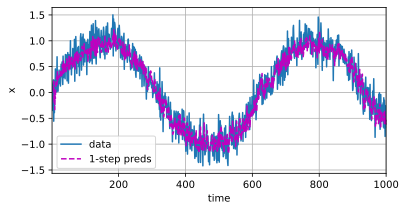

In [116]:

print(features)
onestep_preds = net(features)
#? 注意，这里的net(features)运行的时候，相当于我在预测y_i 的时候 用到了实际的y_i-1 y_i-1 y_i-3 y_i-4
#? 值得在意的是 这里的模型即使在600步以后也是表现得不错的。
#? 但是 如果用这个模型进行测试集合的计算，要先算y_i 再算y_i+1 再算y_i+2 必须按照顺序。
#? 因为每一个元素的输出都是和前面刚好四个 紧密相关的。
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

正如我们所料，单步预测效果不错。
即使这些预测的时间步超过了$600+4$（`n_train + tau`），
其结果看起来仍然是可信的。
然而有一个小问题：如果数据观察序列的时间步只到$604$，
我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到$x_t$的观测序列，其在时间步$t+k$处的预测输出$\hat{x}_{t+k}$
称为$k$*步预测*（$k$-step-ahead-prediction）。
由于我们的观察已经到了$x_{604}$，它的$k$步预测是$\hat{x}_{604+k}$。
换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。
让我们看看效果如何。


In [117]:
multistep_preds = torch.zeros(T)
# print(multistep_preds.shape)
multistep_preds[: n_train + tau] = x[: n_train + tau]
print(n_train + tau) 
# print(multistep_preds)
#? 此时multistep_preds前604项是真实的y_i，之后的都是0.0
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))
    #? 现在计算第i个元素的真实值，传进去的就是i-4 ~ i-1 这四个元素的真实值。
    #? 需要修改一下传进去的维度，所以需要使用reshape

print(multistep_preds)
#? 下面通过画图来看一下结果

604
tensor([-0.3465, -0.0504,  0.1437,  0.1935,  0.2430, -0.5551,  0.1014, -0.3912,
         0.2373, -0.0366,  0.4552,  0.1092,  0.2526,  0.1788,  0.0089,  0.6898,
         0.0772,  0.3099,  0.0254,  0.2757,  0.2989,  0.4333,  0.1697,  0.3397,
         0.2776,  0.1250,  0.2762,  0.5451,  0.3615,  0.3048,  0.5897,  0.4797,
         0.1543,  0.7031,  0.2856,  0.3616,  0.4731,  0.4865,  0.3370,  0.2650,
         0.7338,  0.4279,  0.5981,  0.7265,  0.5493,  0.2251,  0.3657,  0.7711,
         0.6748,  0.1804,  0.7321,  0.5100,  0.5269,  0.6200,  0.5564,  1.0015,
         0.4530,  0.6283,  0.3416,  0.5902,  0.5358,  0.4753,  0.8510,  0.5288,
         0.7686,  0.5022,  0.6137,  1.0270,  0.2181,  0.8871,  0.6438,  1.0814,
         0.8618,  0.5786,  0.3696,  0.7697,  0.6702,  0.8681,  0.5664,  0.8894,
         0.4979,  0.7676,  0.3277,  0.7023,  0.6273,  1.0717,  1.1365,  0.8485,
         0.4329,  0.7035,  0.7912,  1.0716,  0.9948,  1.1279,  0.5303,  0.9587,
         0.6494,  1.0292,  0.5921,  

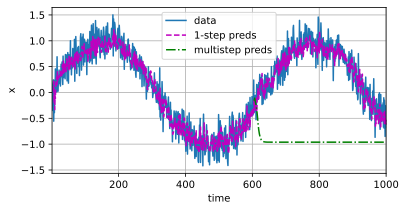

In [118]:

#? 说明：data是真实值
#? one_step_preds存储预测的y_i，在预测的时候使用真实的(x_i-4 ~ x_i-1).
#? multi_step_preds 在604步之后，存储的都是根据自己的结果一步一步进行计算的结果。
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，绿线的预测显然并不理想。
经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。
为什么这个算法效果这么差呢？事实是由于错误的累积：
假设在步骤$1$之后，我们积累了一些错误$\epsilon_1 = \bar\epsilon$。
于是，步骤$2$的输入被扰动了$\epsilon_1$，
结果积累的误差是依照次序的$\epsilon_2 = \bar\epsilon + c \epsilon_1$，
其中$c$为某个常数，后面的预测误差依此类推。
因此误差可能会相当快地偏离真实的观测结果。
例如，未来$24$小时的天气预报往往相当准确，
但超过这一点，精度就会迅速下降。
我们将在本章及后续章节中讨论如何改进这一点。

基于$k = 1, 4, 16, 64$，通过对整个序列预测的计算，
让我们[**更仔细地看一下$k$步预测**]的困难。


In [119]:

#? 接下来的代码 还是使用的 真实 (y_i-tau ~ y_i0 进行的预测。 
#? 只不过 是为了 说明 最后的 结果里面 k 越大 预测的结果 越不好。
max_steps = 64

In [120]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

print(features.shape)
# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

torch.Size([933, 68])


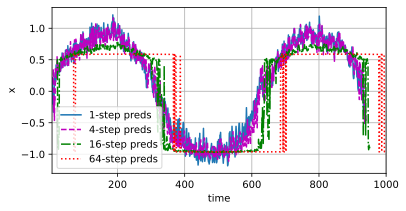

In [121]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

以上例子清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。
虽然“$4$步预测”看起来仍然不错，但超过这个跨度的任何预测几乎都是无用的。



[Discussions](https://discuss.d2l.ai/t/2091)
